In [ ]:
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
EPOCHS = 50
LR = 1e-2
BS = 16384
SEED = 41

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED) # Seed 고정

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/데이콘 콘테스트/데이콘-신용카드 사기 거래 탐지/train.csv')

In [ ]:
train_df = train_df.loc[:,['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V24']]

In [ ]:
train_df

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V24
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-0.689281
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.175575
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,-0.568671,-0.371407,1.341262,0.359894,-0.137134,0.401726,-0.058133,0.068653,-0.371427
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,0.615375,1.249376,-0.619468,0.291474,-1.323865,-0.076127,-1.222127,-0.358222,-0.649709
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,-0.392048,-0.410430,-0.705117,-0.110452,0.074355,-0.210077,-0.499768,0.118765,1.011592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113837,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,4.893089,8.655320,-1.052365,2.834865,1.288401,1.067864,0.586179,-0.085524,-1.253276
113838,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,0.666458,0.120908,-1.134176,0.677729,0.002019,-0.549982,-0.199950,-0.420551,-0.053206
113839,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,0.106234,-0.284708,-0.612982,-0.066655,0.237948,-0.245496,-0.174846,-0.891169,0.371441
113840,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,-0.204064,-0.657422,0.644837,0.190916,-0.731707,0.599628,0.070441,0.373110,0.102800


In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/데이콘 콘테스트/데이콘-신용카드 사기 거래 탐지/val.csv')

In [ ]:
val_class = val_df['Class']
val_data = val_df.drop('ID', axis=1)
val_normal = val_data[val_data['Class']==0]
val_fraud = val_data[val_data['Class']==1]
cols = val_normal.columns[:-1]

In [ ]:
#Zscore를 이용해서 성능 향상
#비지도 학습 시 zscore가 낮은 feature의 경우 제거하여 학습하는 것이 좋은 경우 존재
def ztest(feature):
  mean = val_normal[feature].mean()
  std = val_fraud[feature].std()
  ZScore = (val_fraud[feature].mean()-mean)/(std/np.sqrt(len(val_fraud)))
  return ZScore

In [ ]:
significant_features = []
critical_value = 2

In [ ]:
for i in cols:
  z_value = ztest(i)
  print(i , ':' , z_value)
  if(abs(z_value) >= critical_value):
    significant_features.append(i)

V1 : -4.4526601182785885
V2 : 5.929642159946612
V3 : -5.995242925676357
V4 : 8.654554821045437
V5 : -3.963868977229947
V6 : -6.7752046847723415
V7 : -4.70856915422665
V8 : 1.4622168093026786
V9 : -6.912447203321289
V10 : -6.5941677253873205
V11 : 8.276193882145451
V12 : -7.584065293105052
V13 : 0.26576870038068195
V14 : -9.810267435198172
V15 : -1.238909416176234
V16 : -5.427457894138375
V17 : -5.2912452017598275
V18 : -4.083856057173998
V19 : 1.8508500185937453
V20 : 1.6346826520063453
V21 : -0.04789669313133748
V22 : 1.9696719953549637
V23 : 0.6086704108819003
V24 : -2.0021771832736293
V25 : -0.41281694889402665
V26 : 0.7658211283095404
V27 : -1.423458943056188
V28 : -1.5405432396419392
V29 : -0.5136414852625407
V30 : -1.5643607435994464


In [ ]:
print(significant_features)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V24']


In [ ]:
val_df = val_df.loc[:,['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18','V24','Class']]

In [ ]:
val_df

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V24,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,-0.736727,-0.366846,1.017614,0.836390,-0.443523,0.739453,-0.540980,0.476677,-0.385050,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,-1.191311,0.724396,1.690330,0.406774,0.983739,-0.602232,0.402484,-1.737162,-1.371866,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.896287,0.757952,-0.448937,-0.660863,0.788864,0.295404,-0.287878,-0.451453,0.691320,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.226278,-0.225495,1.944545,1.385160,0.314166,-1.333716,1.002869,-2.119314,-0.992569,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,4.009259,6.051521,2.572500,0.066851,-2.837136,-0.303774,-1.942303,-0.435450,0.515821,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28457,-0.546378,1.433992,-0.313252,0.926044,0.522388,-0.565669,1.066075,-1.099446,-0.077753,0.534689,0.748099,1.018502,-0.914161,0.143397,0.154285,0.030397,0
28458,-0.764523,0.588379,-0.907599,-0.418847,0.901528,-0.760802,0.758545,-0.730854,-1.245088,0.874312,0.162691,-0.317789,0.482847,0.681412,0.486991,0.587119,0
28459,-0.446951,1.302212,-0.168583,0.981577,0.578957,-0.605641,1.253430,-0.417116,0.076605,-1.291228,-0.690868,0.753473,-1.129904,0.319074,-0.201862,-0.038712,0
28460,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,0.435402,0.267772,0.523316,0.559047,0.626211,0.225361,-0.605252,-0.163049,-0.359769,0


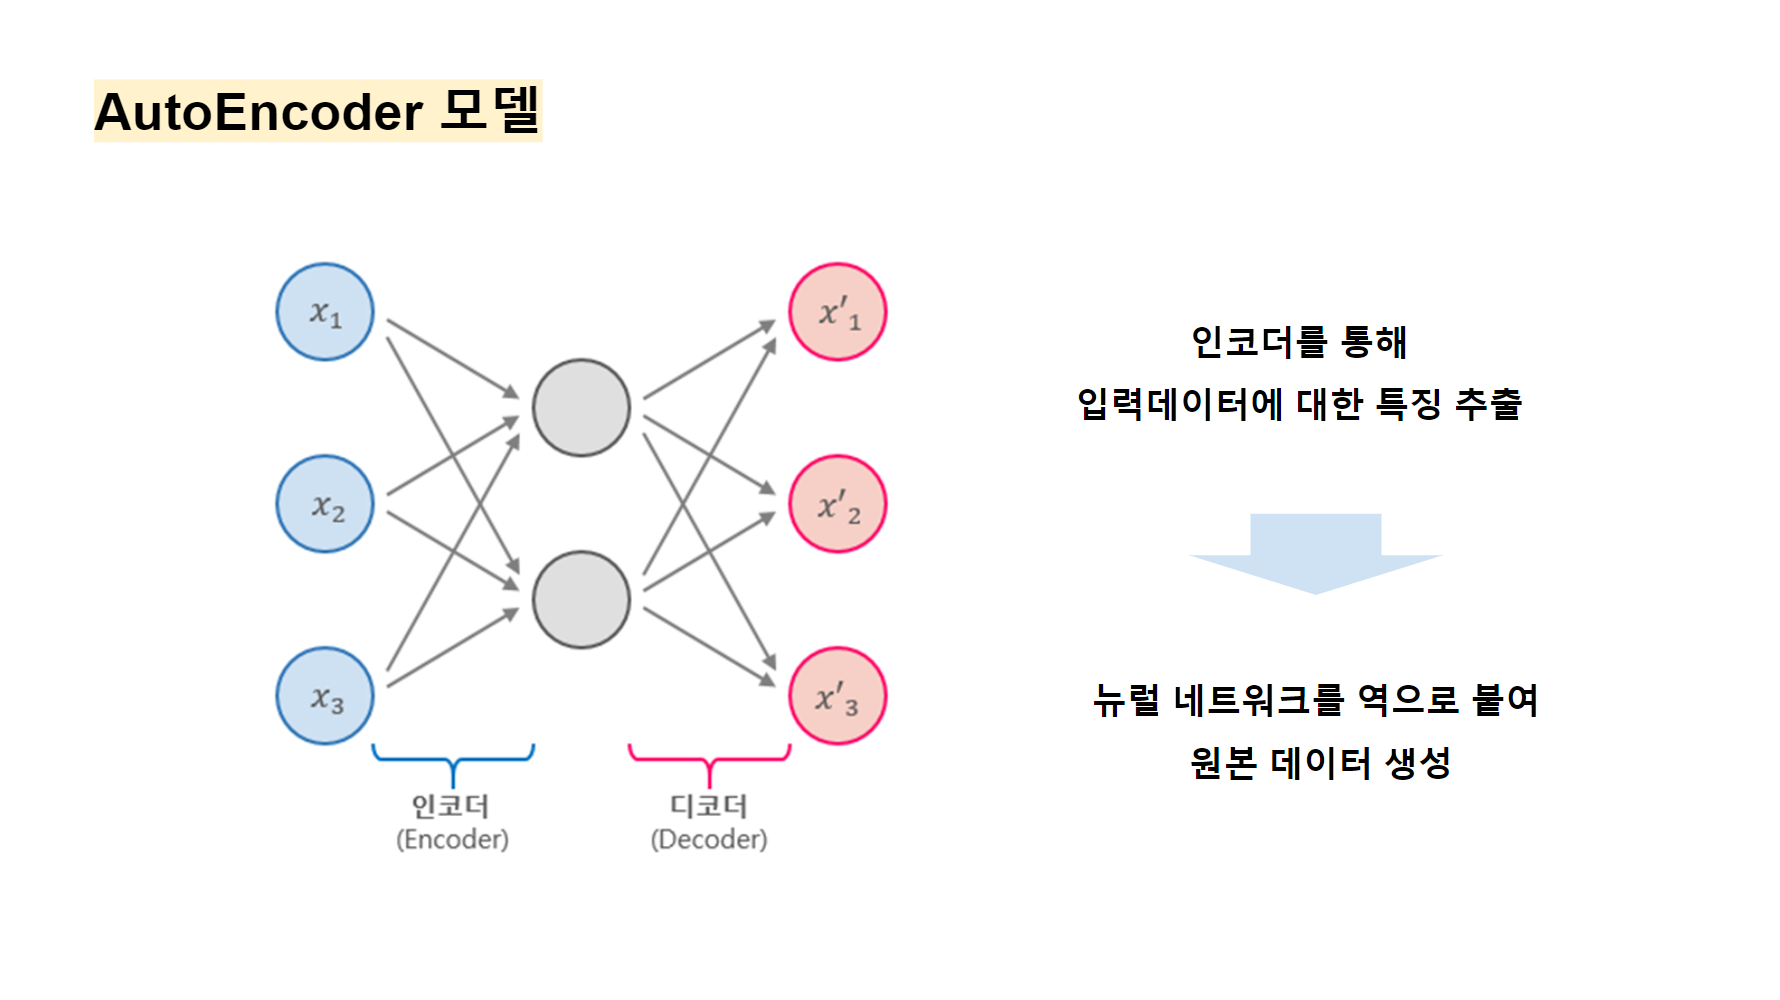

이러한 전처리 후 비지도 학습 모델 중 하나인 오토인코더 모델을 적용. 오토인코더는 뉴럴 네트워크 2개를 뒤집어 붙여놓은 형태로, 인코더를 통해 입력 데이터에 대한 특징을 추출. 이 결과를 바탕으로 뉴럴 네트워크를 역으로 붙여 원본데이터를 생성하는데요, 이 과정에서 입력과 출력 값이 최대한 같아지도록 학습

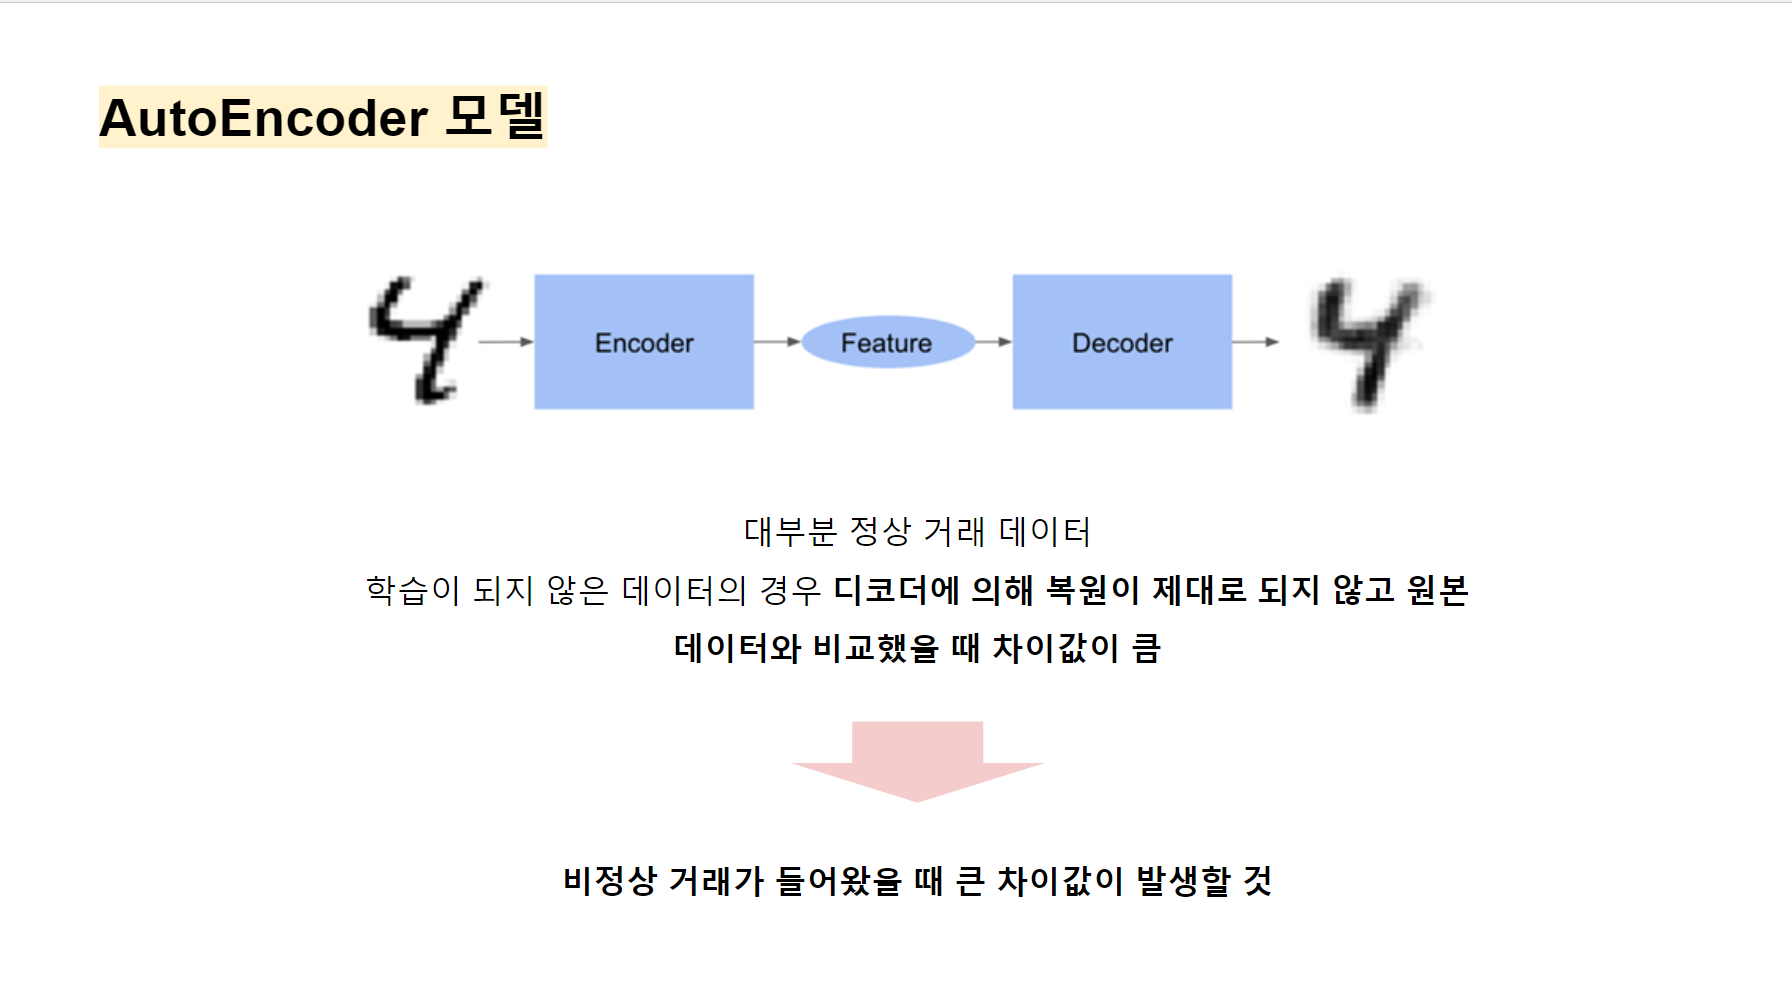

신용카드 거래 데이터를 이 모델에 적용하면, 방대한 양의 데이터 중 사기거래는 굉장히 소수이기 때문에 대부분 정상데이터를 이용해 학습이 진행. 따라서 학습이 진행되지 않은 사기 거래가 입력값으로 들어오면 복원이 제대로 되지 않고 원본과의 차이가 크게 나타날 것

In [ ]:
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        if self.eval_mode:
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
        
    def __getitem__(self, index):
        if self.eval_mode:
            self.x = self.df[index]
            self.y = self.labels[index]
            return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)
        
    def __len__(self):
        return len(self.df)

In [ ]:
train_dataset = MyDataset(df=train_df, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=6)

val_dataset = MyDataset(df = val_df, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=6)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


현재 사용하는 데이터셋은 보통 오토인코더 모델에 적용하는 데이터셋에 비교해 차원이 작음. -> 일반적인 오토인코더 모델과는 달리 인코더 과정에서는 차원을 확대하고, 디코더 과정에서 다시 차원을 축소하는 방법을 이용

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(   #인코더
            nn.Linear(16,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
        )
        self.Decoder = nn.Sequential(   #디코더
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64,16),
        )
        
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

In [ ]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.L1Loss().to(self.device)
        
    def fit(self, ):
        self.model.to(self.device)
        best_score = 0
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()

                _x = self.model(x)
                loss = self.criterion(x, _x)

                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            score = self.validation(self.model, 0.95)
            print(f'Epoch : [{epoch}] Train loss : [{np.mean(train_loss)}] Val Score : [{score}])')

            if self.scheduler is not None:
                self.scheduler.step(score)

            if best_score < score:
                best_score = score
                torch.save(model.module.state_dict(), './best_model.pth', _use_new_zipfile_serialization=False)
    
    def validation(self, eval_model, thr):
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        eval_model.eval()
        pred = []
        true = []
        with torch.no_grad():
            for x, y in iter(self.val_loader):
                x = x.float().to(self.device)

                _x = self.model(x)
                diff = cos(x, _x).cpu().tolist()
                batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
                pred += batch_pred
                true += y.tolist()

        return f1_score(true, pred, average='macro')

In [ ]:
model = nn.DataParallel(AutoEncoder())
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [0] Train loss : [0.5652648934296199] Val Score : [0.08818434620357474])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [1] Train loss : [0.3112866835934775] Val Score : [0.3431990183524472])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [2] Train loss : [0.21047315427235194] Val Score : [0.4423373274575171])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [3] Train loss : [0.16308479862553732] Val Score : [0.49917879997557246])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [4] Train loss : [0.13437978497573308] Val Score : [0.5399419184147821])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [5] Train loss : [0.11850520649126597] Val Score : [0.6218040025314471])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [6] Train loss : [0.1061033649103982] Val Score : [0.7353562550268086])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [7] Train loss : [0.09925894864967891] Val Score : [0.8045965667777433])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [8] Train loss : [0.09480541305882591] Val Score : [0.833113452596645])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [9] Train loss : [0.08981876181704658] Val Score : [0.8519279892324237])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [10] Train loss : [0.08734215902430671] Val Score : [0.872984830495149])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [11] Train loss : [0.08693472508873258] Val Score : [0.872984830495149])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [12] Train loss : [0.08362252690962382] Val Score : [0.890501890608512])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [13] Train loss : [0.07957722140210015] Val Score : [0.890501890608512])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [14] Train loss : [0.07641412317752838] Val Score : [0.9031202878275757])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [15] Train loss : [0.07720883722816195] Val Score : [0.9031202878275757])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [16] Train loss : [0.07728648717914309] Val Score : [0.9031202878275757])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [17] Train loss : [0.07511366478034429] Val Score : [0.9097393418694286])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [18] Train loss : [0.07629954921347755] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [19] Train loss : [0.07467005188976016] Val Score : [0.9031202878275757])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [20] Train loss : [0.07191825764519828] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [21] Train loss : [0.07165783963033132] Val Score : [0.9031202878275757])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [22] Train loss : [0.07176474056073598] Val Score : [0.9097393418694286])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [23] Train loss : [0.07097467460802623] Val Score : [0.9097393418694286])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [24] Train loss : [0.07234313551868711] Val Score : [0.9097393418694286])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [25] Train loss : [0.06923069272722517] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [26] Train loss : [0.06776967112507139] Val Score : [0.9097393418694286])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [27] Train loss : [0.06784784580980029] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [28] Train loss : [0.06601757130452565] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [29] Train loss : [0.06662366964987346] Val Score : [0.9165787375726882])
Epoch 00030: reducing learning rate of group 0 to 5.0000e-03.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [30] Train loss : [0.0597943195274898] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [31] Train loss : [0.05939275611724172] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [32] Train loss : [0.05661990653191294] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [33] Train loss : [0.05541898310184479] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [34] Train loss : [0.05644242625151362] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [35] Train loss : [0.05430035665631294] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [36] Train loss : [0.05679468012281826] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [37] Train loss : [0.05546085110732487] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [38] Train loss : [0.05551734673125403] Val Score : [0.9097393418694286])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [39] Train loss : [0.05565784392612321] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [40] Train loss : [0.05584750058395522] Val Score : [0.9165787375726882])
Epoch 00041: reducing learning rate of group 0 to 2.5000e-03.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [41] Train loss : [0.05340435994522912] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [42] Train loss : [0.05069672954933984] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [43] Train loss : [0.04954605496355465] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [44] Train loss : [0.048277570200817924] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [45] Train loss : [0.04978169500827789] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [46] Train loss : [0.05064887713108744] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [47] Train loss : [0.051422017493418286] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [48] Train loss : [0.05236755843673434] Val Score : [0.9165787375726882])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : [49] Train loss : [0.04873096889683178] Val Score : [0.9165787375726882])


In [ ]:
model = AutoEncoder()
model.load_state_dict(torch.load('./best_model.pth'))
model = nn.DataParallel(model)
model.eval()

DataParallel(
  (module): AutoEncoder(
    (Encoder): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=64, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=128, out_features=256, bias=True)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
    )
    (Decoder): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/데이콘 콘테스트/데이콘-신용카드 사기 거래 탐지/test.csv')
test_df = test_df.loc[:,['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18','V24']]

In [ ]:
test_df

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V24
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.066928
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.339846
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.141267
3,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.464960,-0.099254,-1.416907,-0.153826,0.167372,-0.443587,0.002821,-0.611987,-0.780055
4,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,-0.558895,0.309755,-0.259116,-0.326143,0.362832,-0.129487,-0.809979,0.359985,0.996710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142498,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,-0.285670,-0.111640,-1.109232,-0.453235,1.122674,-1.431897,0.939328,-0.002373,0.057688
142499,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,1.159498,-0.594242,-1.264072,0.453596,-0.858719,-0.644646,0.447184,0.388721,0.745323
142500,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.584800,-0.975926,-0.150189,0.915802,-0.675143,-0.711757,-0.025693,-1.221179,-1.016226
142501,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.432454,-0.484782,0.411614,0.063119,-0.510602,0.140716,0.313502,0.395652,0.640134


In [ ]:
test_dataset = MyDataset(test_df, False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=6)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
test_dataset

In [ ]:
test_loader

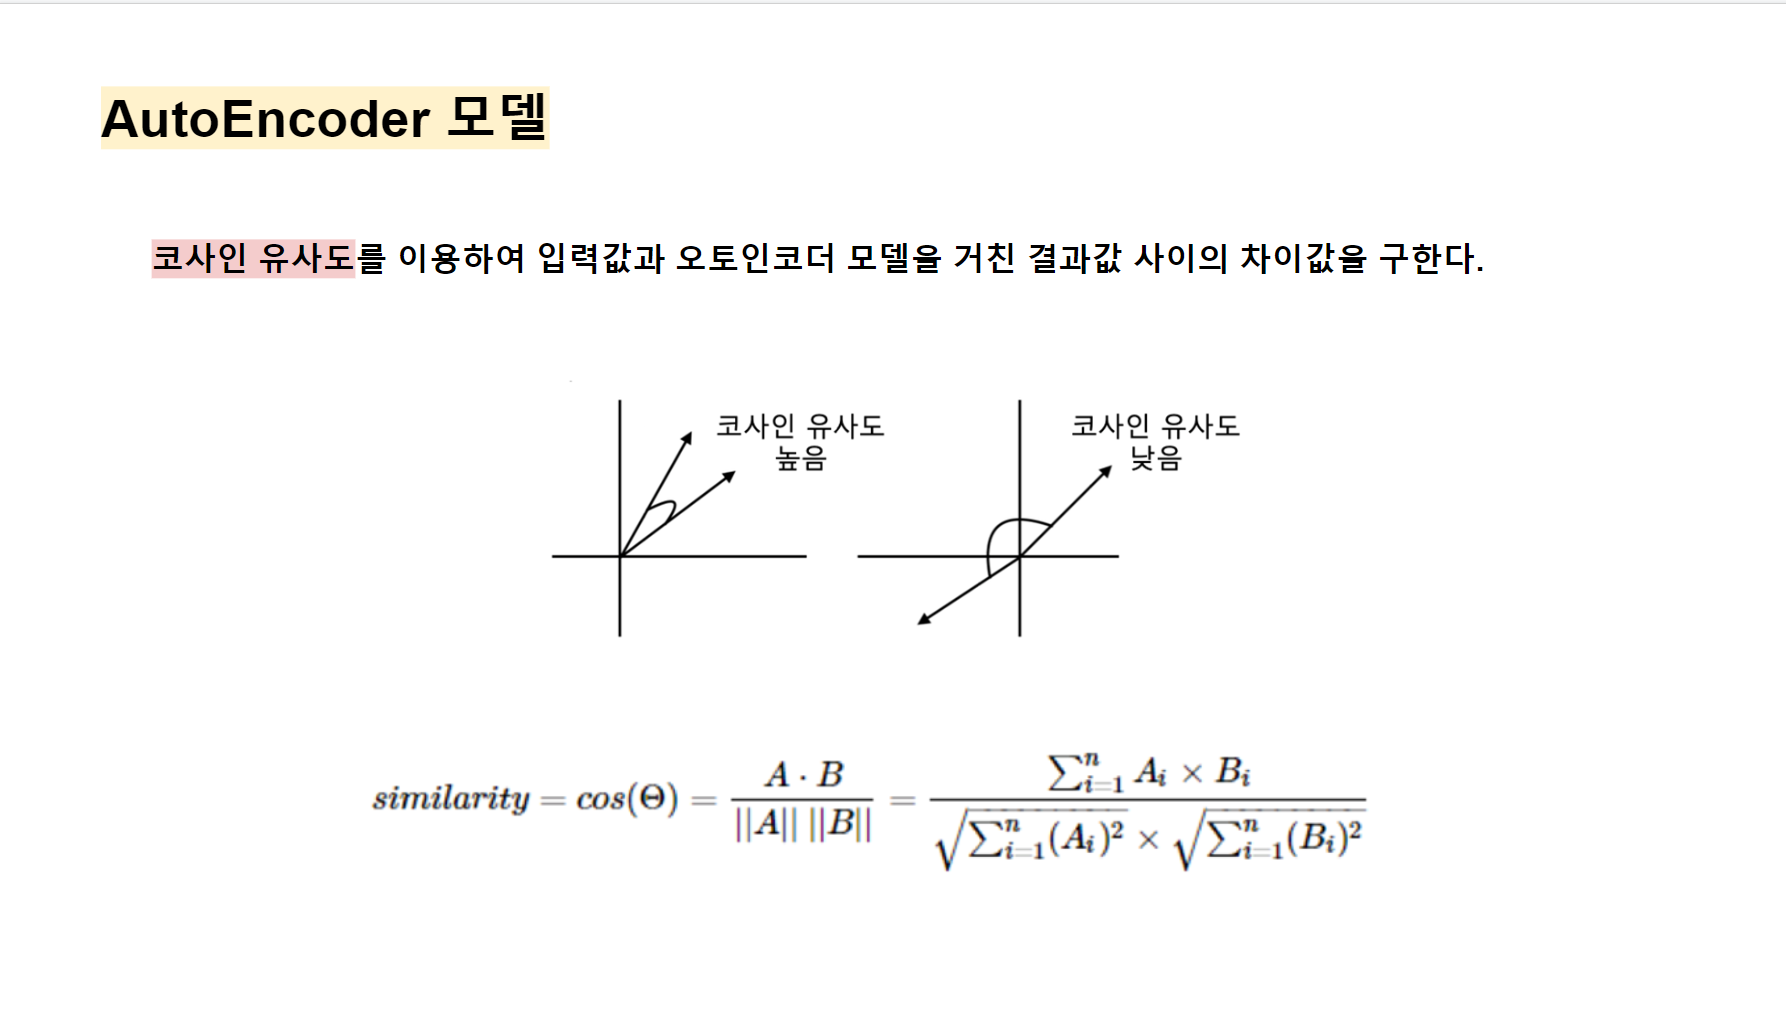

In [ ]:
def prediction(model, thr, test_loader, device):
    model.to(device)
    model.eval()
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    pred = []
    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            
            _x = model(x)
            
            diff = cos(x, _x).cpu().tolist()
            batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
            pred += batch_pred
    return pred

In [ ]:
preds = prediction(model, 0.95, test_loader, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/데이콘 콘테스트/데이콘-신용카드 사기 거래 탐지/sample_submission.csv')
submit.head()

,ID,Class
0,AAAA0x1,1
1,AAAA0x2,1
2,AAAA0x5,1
3,AAAA0x7,1
4,AAAA0xc,1


In [ ]:
submit['Class'] = preds
submit.to_csv('/content/drive/MyDrive/데이콘 콘테스트/데이콘-신용카드 사기 거래 탐지/submit0715.csv', index=False)